 # SARIMA Model for stock prediction

The Seasonal Autoregressive Integrated Moving Average (SARIMA) model combines simpler models in order to capture moving averages throughout time series, taking into account trend, seasonality, and noise. 

We will build, train and test a SARIMA model for predicting WFC Adjusted Close price patterns.



## 2. Install/import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from scipy import stats
from scipy.stats import zscore

from pmdarima.arima.utils import ndiffs

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from itertools import product
from tqdm.notebook import tqdm

import datetime
from datetime import date, timedelta
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')
import time
import pgzip
import pickle

%matplotlib inline

## 3. Import data

In [2]:
ticker = 'WFC'

df = yf.download(ticker,period='10y',interval='1d')

ticker_adj = df[['Adj Close']].copy()
ticker_adj

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2012-06-22,24.635532
2012-06-25,24.192526
2012-06-26,24.275122
2012-06-27,24.575459
2012-06-28,24.387747
...,...
2022-06-15,38.169998
2022-06-16,37.650002
2022-06-17,38.480000


In [3]:
# Plot Adjusted Close price

def ticker_adj_plot():
  sns.set(rc={'figure.figsize':(16, 8)})
  ticker_adj.plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

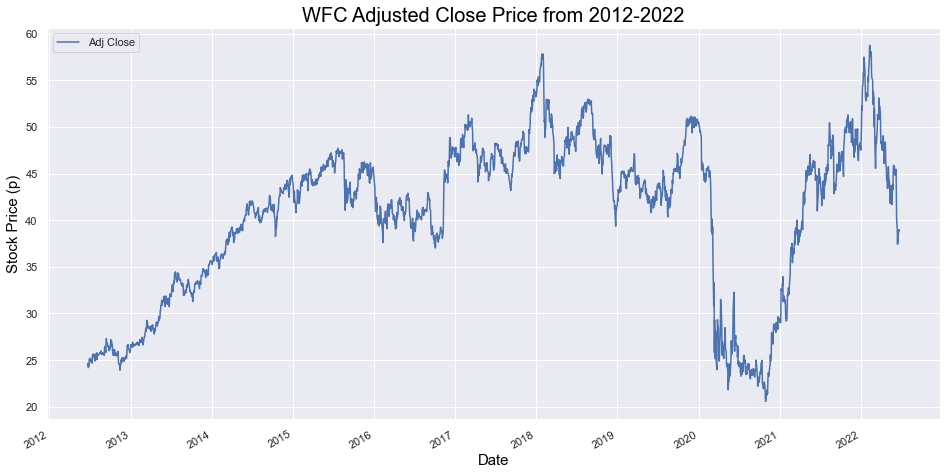

In [4]:
title_txt = f'{ticker} Adjusted Close Price from 2012-2022'
label_txt = f'{ticker} Adj Close'

ticker_adj_plot()

In [5]:
#  Create DataFrame of Adjusted Close prices from the last 2500 periods

ticker_adj_1000 = ticker_adj[-2500:]

In [6]:
ticker_adj.shape

(2516, 1)

In [7]:
# Plot last 1000 periods

def ticker_adj_1000_plot():
  sns.set(rc={'figure.figsize':(16, 8)})
  ticker_adj_1000.plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

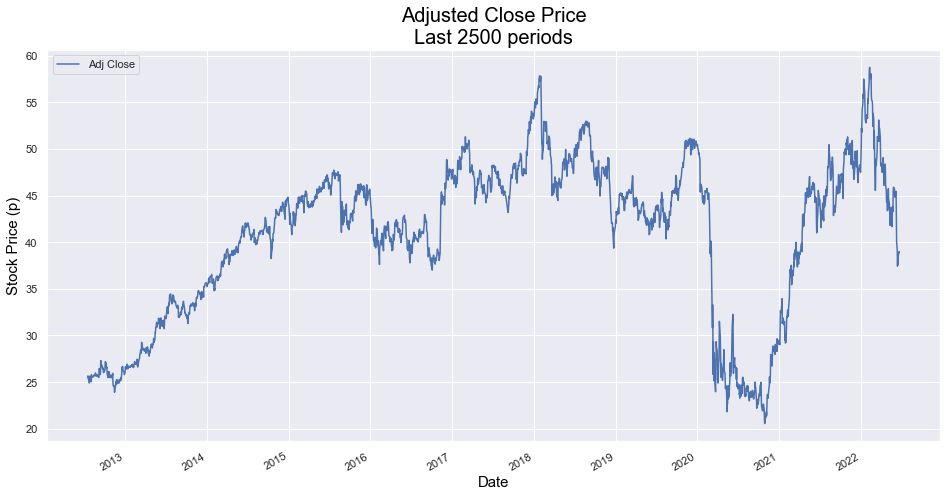

In [8]:
title_txt = "Adjusted Close Price\nLast 2500 periods"
label_txt = f'{ticker} Adj Close'

ticker_adj_1000_plot()

## 4. Stationarity

Before modelling with SARIMA we must apply transformations to our time series to remove seasonality and any non-stationary behaviours.

### 4.1 Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

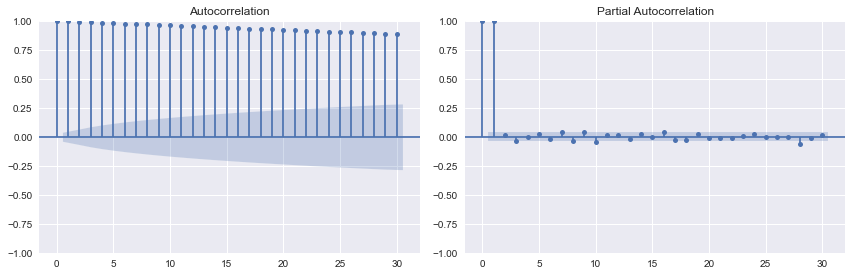

In [9]:
# ACF and PACF for original non-differenced data

def acf_pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
acf_pacf_plot(ticker_adj_1000, lags=30)

There is clearly high autocorrelation. We will run an ADF test to further test for stationarity.

### 4.2 Augmented Dickey-Fuller (ADF) test

In [10]:
# Check if price series is stationary
# Augmented Dickey-Fuller test

result = adfuller(ticker_adj_1000.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.514463313869098
p-value: 0.11199478669269125


The p-value is greater than the significance level of 0.05 so we cannot reject the null hypothesis that the process is not stationary. The next step is to determine the order of differencing required to make the series stationary.


### 4.3 Differencing

In [11]:
# Detrend by first order differencing to achieve lower p-value

result = adfuller(ticker_adj_1000.diff().dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -16.15547774191754
p-value: 4.5228806253270145e-29


The p-value is now much less than the significance level of 0.05 so the null hypothesis is rejected, and the process is considered to be stationary.

In [12]:
# Create DataFrame of differenced prices

ticker_adj_1000_diff = ticker_adj_1000.diff().dropna()

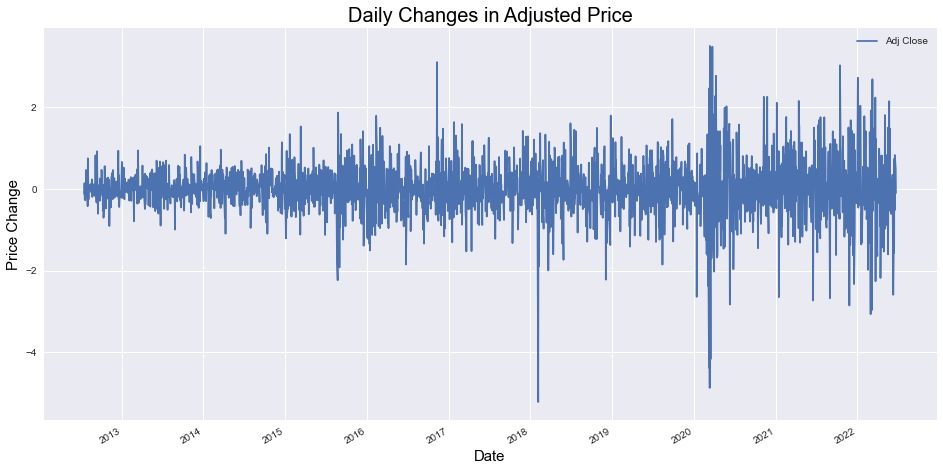

In [13]:
# Plot returns

def returns_plot():
  plt.style.use('seaborn')
  ticker_adj_1000_diff.plot(figsize=(16,8))
  plt.title("Daily Changes in Adjusted Price", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Price Change', color = 'black', fontsize = 15);
  plt.show()

returns_plot()

We can see that the returns randomly distribute around the mean of 0.

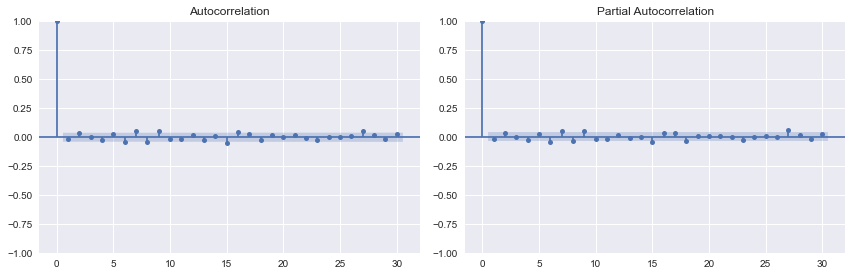

In [14]:
# ACF and PACF for the differenced data

def acf_pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
acf_pacf_plot(ticker_adj_1000_diff, lags=30)

The plots above resemble those of white noise, therefore this model is ready to be used for forecasting.

## 5. Select parameters for modelling


A **SARIMA(p, d, q)(P, D, Q, s)** model takes the parameters: 
*   **AR(p)** from the Autoregression model representing the maximum lag,
*   **MA(q)** from the Moving Average model representing the biggest lag after which other lags are not significant on the ACF plot
*  The order of **Integration (d)** representing the number of
differences required to make the series stationary
* **Seasonality** in (P, D, Q, s) where **s** is the season's length, **P** and **Q** are the same as **p** and **q** but for the seasonal component, and **D** is the order of seasonal integration representing the number of differences required to remove seasonality from the series. 

A **SARIMAX** implementation is so-called because the **X** addition means that it also supports exogenous variables. This is an optional argument, rather than a parameter, for parallel time series variates made available as a weighted input to the model.

### 5.1 Grid search to select the best order for SARIMA model

In [15]:
# Grid search function to iteratively explore different combinations of parameters

def best_param(model, data, pdq, pdqs):
    """
    Iterates through and runs model for all combinations for pdq and pdqs 
    to find model with lowest AIC score

    :param model: SARIMAX
    :param data: time series data 
    :param pdq: list with (p, d, q) tuples
    :param pdqs: list with (p, d, q, s) tuples 

    :returns: parameters and corresponding lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

### 5.2 Parameters to iterate through

In [16]:
# Set initial values and some bounds for p, d, q.
p = d = q = range(0,5)
d = [1]

# Creating a list of all possible parameter combinations of p, d, q.
pdq = list(product(p, d, q))


# Add seasonal component to (p, d, q)
pdqs = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]


### 5.3 Search for optimum parameters

In [17]:
# Finding best parameters for model

# best_param(SARIMAX, ticker_adj_1000, pdq, pdqs)

## 6. Modelling

### 6.1 Define training and test set

In [18]:
# Split data into train and test set 

index = round(len(ticker_adj_1000)*.80)

train = ticker_adj_1000.iloc[:index]
test = ticker_adj_1000.iloc[index:]

### 6.2 Fit and train the model

In [19]:
# Fit best model to training data

model = SARIMAX(train, 
                order=(0, 1, 4), 
                seasonal_order=(2,1,4,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
start = time.time()
output = model.fit()
end = time.time()

print(end-start)

323.70478534698486


### Output summary of best model

In [20]:
print(output.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                 2000
Model:             SARIMAX(0, 1, 4)x(2, 1, 4, 12)   Log Likelihood               -1853.470
Date:                            Wed, 22 Jun 2022   AIC                           3728.940
Time:                                    19:57:22   BIC                           3790.181
Sample:                                         0   HQIC                          3751.464
                                           - 2000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0260      0.012     -2.230      0.026      -0.049      -0.003
ma.L2          0.0618      0.011   

We can see that the best performing model has both seasonal and non-seasonal moving average processes and seasonal autoregressive processes.

### Study the residuals

In [21]:
# Ljung-Box test and Augmented Dickey-Fuller test 
ljung_box, p_value = acorr_ljungbox(output.resid)

print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: lb_stat
p-value: lb_pvalue


Looking at the p-values above, we can see that they are above 0.05, therefore we cannot reject the null hypothesis, and the residuals are are independent and not correlated.

### Plot residuals

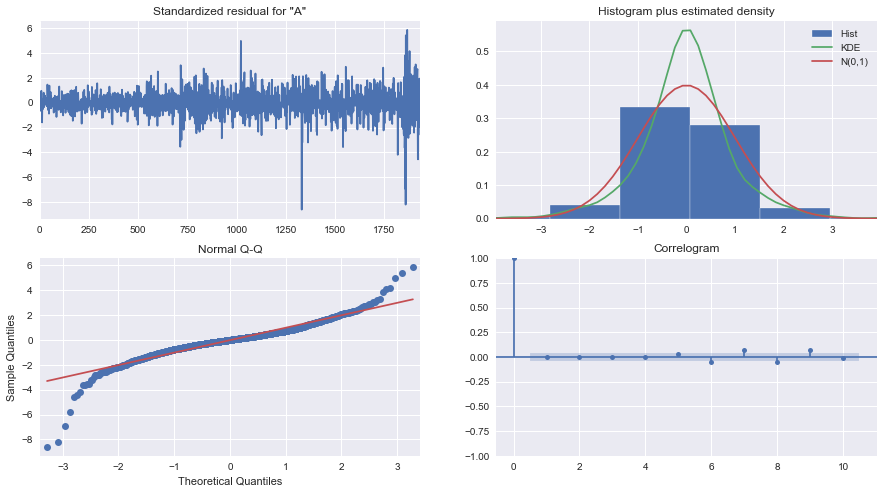

In [22]:
output.plot_diagnostics(figsize=(15,8))
plt.show()

The correlogram, or ACF plot, shows no autocorrelation in the results as none are over the significance level and are just white noise. The normal Q-Q plot is almost straight suggesting no systematic departure from normality.

### 6.3 Test the model

In [23]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = pd.Series(fc.predicted_mean.values, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf.iloc[:, 1].values, index=test.index)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(dynamic=False)
pred        = predictions.predicted_mean

# Confidence interval for the training set
conf_int   = predictions.conf_int()
low_conf   = pd.Series(conf_int.iloc[:,0], index=train.index)
upper_conf = pd.Series(conf_int.iloc[:,1], index=train.index)

### Plot train, test, predicted values and confidence interval

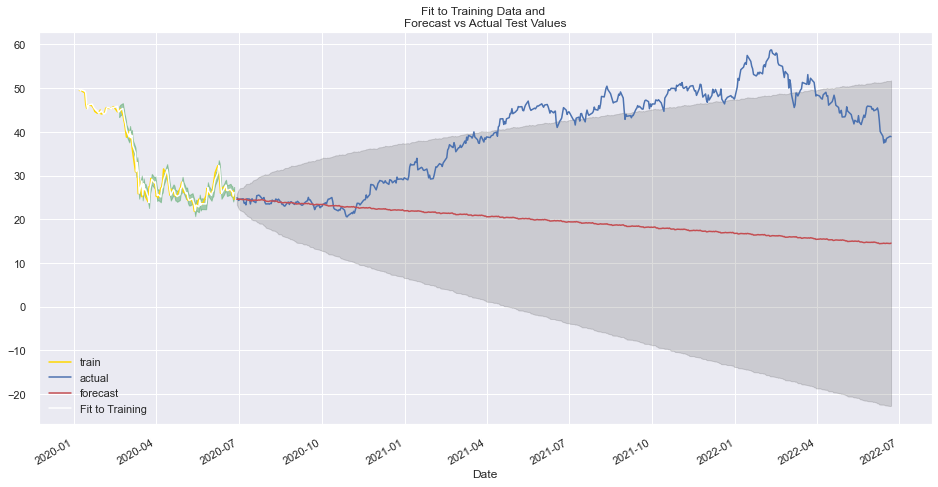

In [24]:
sns.set(rc={'figure.figsize':(16, 8)})

# Plotting the training set, test set, forecast, and confidence interval.
plt.plot(train[-120:], label='train', color='gold')
plt.plot(test, label='actual', color='b')
plt.plot(fc_series, label='forecast', color='r')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred[-120:].plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int[-90:].index, conf_int[-90:].iloc[:,0], conf_int[-90:].iloc[:,1], color='g',alpha=.5)

plt.title('Fit to Training Data and \nForecast vs Actual Test Values')
plt.legend()
plt.show()

###  6.4 Evaluate the model

In [25]:
# Calculate the RMSE

forecast = pred
actual_val = train['Adj Close']

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  0.9063470582315616


In [26]:
np.sqrt(np.mean(np.square(np.abs(actual_val - forecast))))

0.9063470582315616

### 6.5 Predict future values 

In [27]:
ticker_adj_2500 = ticker_adj[-2500:]

In [28]:
# Fitting and training with the entire dataset 


model = SARIMAX(ticker_adj_2500, 
                order=(0, 1, 4), 
                seasonal_order=(2,1,4,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
start = time.time()
output_recent = model.fit()
end = time.time()

print(end-start)

379.68600940704346


In [29]:
output_recent.last_time = ticker_adj_2500.iloc[-1].name

In [30]:
# import joblib
# joblib.dump(output_recent, f'models/sarima_{ticker}_2500.pkl', compress=9)

In [31]:
# output_recent.save(f'models/sarima_{ticker}_2500.pkl')
with pgzip.open(f'models/sarima_{ticker}_2500.pkl', 'wb') as f:
    pickle.dump(output_recent, f)

In [32]:
#dummy value for loading
ticker_adj_1 = ticker_adj[-1:]

In [33]:
# Fitting and training with the entire dataset 


model = SARIMAX(ticker_adj_1, 
                order=(0, 1, 4), 
                seasonal_order=(2,1,4,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
start = time.time()
output1 = model.fit()
end = time.time()

print(end-start)

0.09200000762939453


In [34]:
start = time.time()

In [35]:
# t = output1.load(f'models/sarima_{ticker}_2500.pkl')
with pgzip.open(f'models/sarima_{ticker}_2500.pkl', 'rb') as f:
    t = pickle.load(f)

In [36]:
# Getting the forecast of future values
future = t.get_forecast(steps=30,)

# Predicted values
pred_fut = pd.Series(future.predicted_mean.values, 
                     index=pd.date_range(start=ticker_adj_1000.index[-1]+datetime.timedelta(days=1), periods=30, freq="D"))

# Confidence interval for our forecasted values
pred_conf = pd.DataFrame(future.conf_int().values, 
                      index=pd.date_range(start=ticker_adj_1000.index[-1]+datetime.timedelta(days=1), periods=30, freq="D"))

# Saving last daily prediction for later
d90 = pred_fut[-1]

### Plot the predicted values

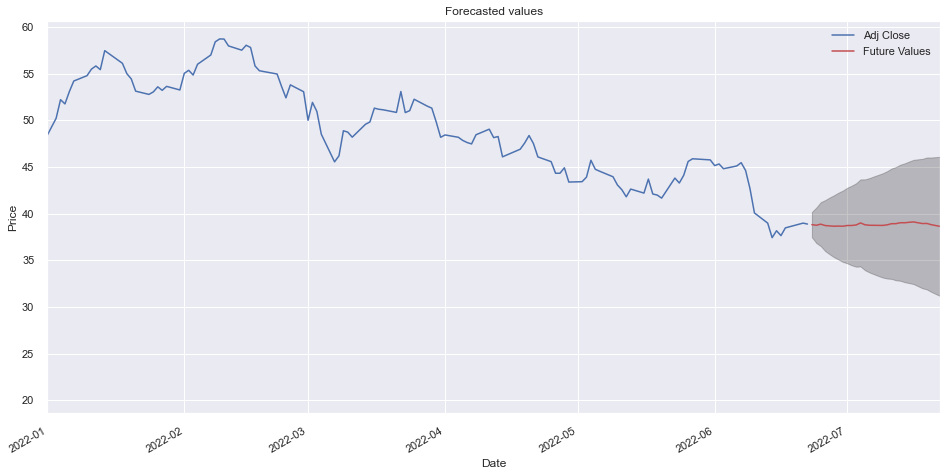

In [37]:
# Plotting the prices up to the most recent
ax = ticker_adj_1000.plot(label='Actual', figsize=(16,8))

# Plotting the forecast
pred_fut.plot(ax=ax, label='Future Values', color='r')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.xlim(['2022', pred_fut.index[-1]])
plt.title('Forecasted values')
plt.legend()
plt.show()

### Print prediction

## Add new data to stored model whenever script runs for future prediction

In [38]:
df1 = yf.download(ticker,period='30d',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [39]:
df1 = df1[['Adj Close']]

In [40]:
df1 = df1[df1.index > t.last_time]

In [41]:
temp = df1.values

In [42]:
temp

array([], shape=(0, 1), dtype=float64)

In [43]:
if len(temp) != 0:
    t = t.append(temp)
    t.last_time = df1.iloc[-1].name
    print(df1.iloc[-1].name)
#     t.save(f'models/sarima_{ticker}_2500.pkl')
    with pgzip.open(f'models/sarima_{ticker}_2500.pkl', 'wb') as f:
        pickle.dump(t, f)

In [44]:
end = time.time()
print(end-start)

6.190998077392578


In [45]:
# ticker_adj_1000.iloc[-1]

In [46]:
ticker_adj_1000.index[-1]+datetime.timedelta(days=len(temp))

Timestamp('2022-06-22 00:00:00')

In [47]:
# Getting the forecast of future values
future = t.get_forecast(steps=30,)

# Predicted values
pred_fut = pd.Series(future.predicted_mean.values, 
                     index=pd.date_range(start=t.last_time+datetime.timedelta(days=len(temp)), periods=30, freq="D"))

# Confidence interval for our forecasted values
pred_conf = pd.DataFrame(future.conf_int().values, 
                      index=pd.date_range(start=t.last_time+datetime.timedelta(days=len(temp)), periods=30, freq="D"))

# Saving last daily prediction for later
d30 = pred_fut[-1]

In [48]:
# plt.plot(pred_fut[:30])

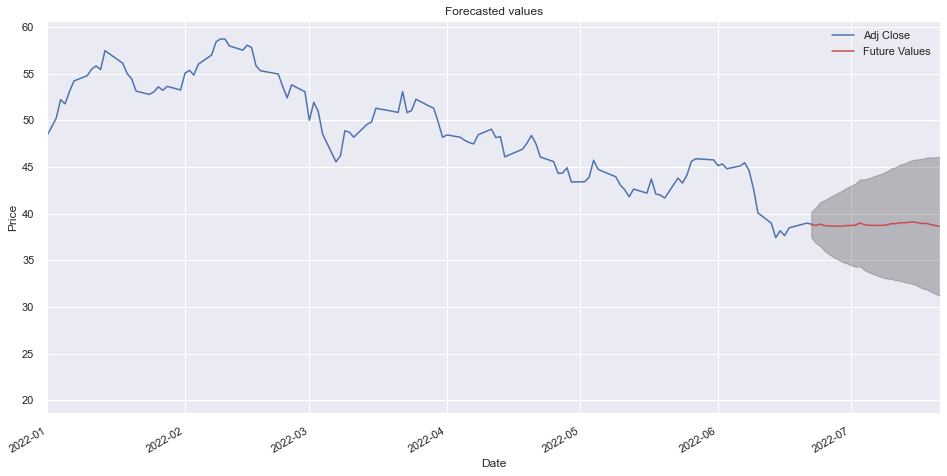

In [49]:
# Plotting the prices up to the most recent
ax = ticker_adj_1000.plot(label='Actual', figsize=(16,8))

# Plotting the forecast
pred_fut.plot(ax=ax, label='Future Values', color='r')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.xlim(['2022', pred_fut.index[-1]])
plt.title('Forecasted values')
plt.legend()
plt.show()

In [50]:
sarimax_preds = pd.DataFrame([d30], index=['day'], columns=['prediction'])
sarimax_preds

,prediction
day,38.639029


In [51]:
pred_fut

2022-06-22    38.826877
2022-06-23    38.759350
2022-06-24    38.879632
2022-06-25    38.728251
2022-06-26    38.693766
2022-06-27    38.656308
2022-06-28    38.671536
2022-06-29    38.655827
2022-06-30    38.732142
2022-07-01    38.735598
2022-07-02    38.789464
2022-07-03    39.009875
2022-07-04    38.811882
2022-07-05    38.759721
2022-07-06    38.754692
2022-07-07    38.747195
2022-07-08    38.744640
2022-07-09    38.801082
2022-07-10    38.925994
2022-07-11    38.931148
2022-07-12    39.031621
2022-07-13    39.028422
2022-07-14    39.078973
2022-07-15    39.116226
2022-07-16    39.028620
2022-07-17    38.943192
2022-07-18    38.955089
2022-07-19    38.823374
2022-07-20    38.729676
2022-07-21    38.639029
Freq: D, dtype: float64

In [52]:
pred_conf.iloc[:, 0]

2022-06-22    37.470651
2022-06-23    36.856470
2022-06-24    36.525264
2022-06-25    35.998839
2022-06-26    35.653170
2022-06-27    35.333543
2022-06-28    35.088757
2022-06-29    34.830667
2022-06-30    34.679071
2022-07-01    34.466766
2022-07-02    34.315263
2022-07-03    34.339328
2022-07-04    33.944045
2022-07-05    33.702425
2022-07-06    33.514466
2022-07-07    33.330247
2022-07-08    33.156791
2022-07-09    33.047405
2022-07-10    33.011138
2022-07-11    32.859388
2022-07-12    32.806912
2022-07-13    32.654433
2022-07-14    32.559120
2022-07-15    32.453703
2022-07-16    32.226343
2022-07-17    32.003984
2022-07-18    31.881596
2022-07-19    31.618098
2022-07-20    31.394987
2022-07-21    31.177172
Freq: D, Name: 0, dtype: float64

In [53]:
pred_conf.iloc[:, 1]

2022-06-22    40.183104
2022-06-23    40.662230
2022-06-24    41.234001
2022-06-25    41.457663
2022-06-26    41.734363
2022-06-27    41.979073
2022-06-28    42.254316
2022-06-29    42.480987
2022-06-30    42.785214
2022-07-01    43.004430
2022-07-02    43.263664
2022-07-03    43.680422
2022-07-04    43.679719
2022-07-05    43.817016
2022-07-06    43.994917
2022-07-07    44.164143
2022-07-08    44.332490
2022-07-09    44.554758
2022-07-10    44.840851
2022-07-11    45.002907
2022-07-12    45.256330
2022-07-13    45.402411
2022-07-14    45.598826
2022-07-15    45.778749
2022-07-16    45.830896
2022-07-17    45.882401
2022-07-18    46.028583
2022-07-19    46.028650
2022-07-20    46.064364
2022-07-21    46.100887
Freq: D, Name: 1, dtype: float64

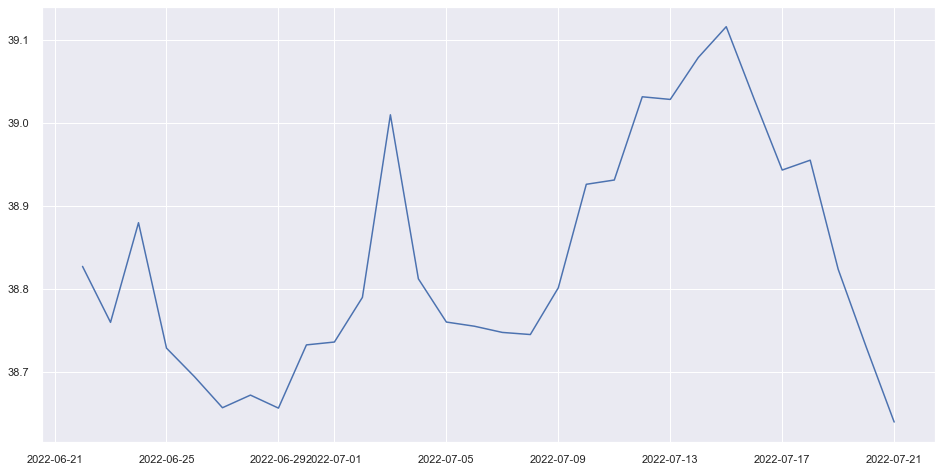

In [54]:
plt.plot(pred_fut[:30])

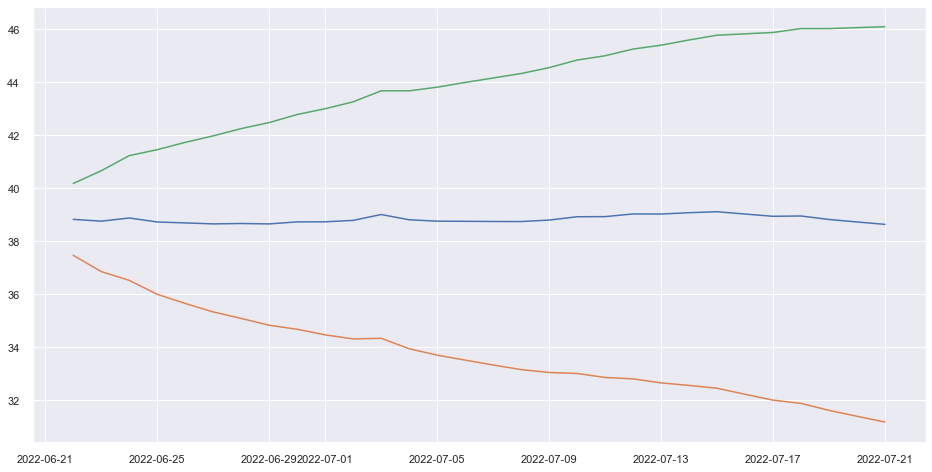

In [55]:
plt.plot(pred_fut[:30])
plt.plot(pred_conf.iloc[:, 0][:30])
plt.plot(pred_conf.iloc[:, 1][:30])
plt.show()

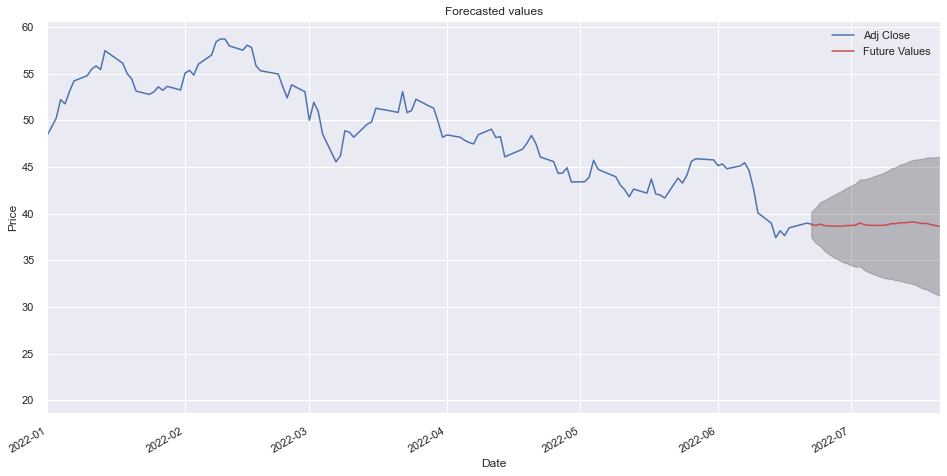

In [56]:
ax = ticker_adj_1000.plot(label='Actual', figsize=(16,8))

# Plotting the forecast
pred_fut[:30].plot(ax=ax, label='Future Values', color='r')

# Shading in the confidence interval
ax.fill_between(pred_conf[:30].index,
                pred_conf[:30].iloc[:, 0],
                pred_conf[:30].iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.xlim(['2022', pred_fut.index[-1]])
plt.title('Forecasted values')
plt.legend()
plt.show()